In [58]:
import os
import sys
os.environ["THEANO_FLAGS"] = "device=cpu"
sys.path.append(os.getcwd()+"/..")
import lasagne
import theano.tensor as T
import theano
from tasks import check

In [164]:
v = check(what="notebook", 
          #filename="..//model.pkl", 
          filename="../training/reproduce_bengio_denoising/minibatch/model.pkl",
          dataset="digits")

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...


{'seed': 2}


In [166]:
capsule, data, layers, w, h, c = v
print(w, h, c)
print(layers.keys())

(28, 28, 1)
['input', 'hid', 'hid_sparse', 'pre_output', 'output']


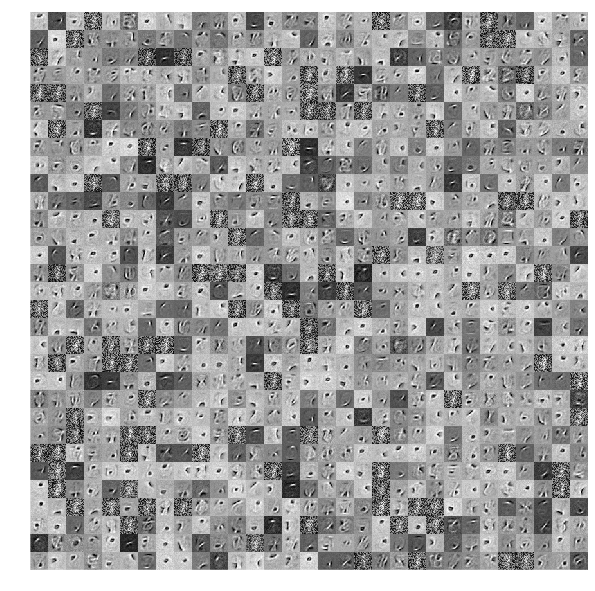

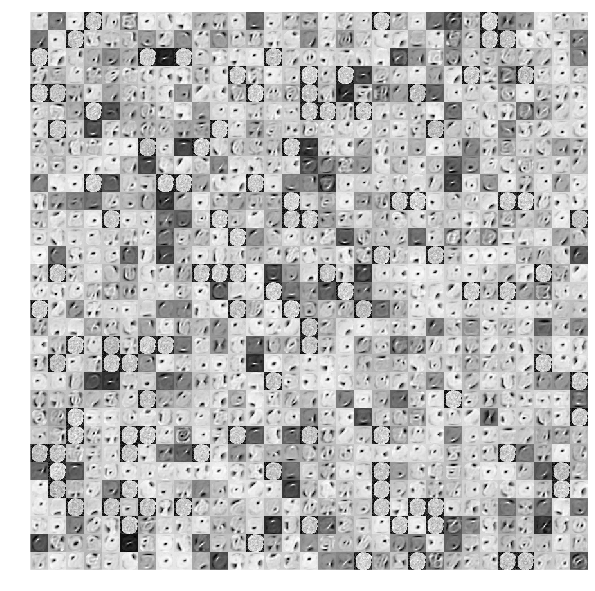

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
for name, layer in layers.items():
    #print(name, layer.output_shape)
    #if hasattr(layer, "W"):
    #    print(layer.W.get_value().shape)
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2:
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            a, b = w, h
        else:
            W = W.reshape((W.shape[0]*W.shape[1], W.shape[2], W.shape[3]))
            a, b = W.shape[1:]
        fig = plt.figure(figsize=(10, 10))
        s = int(np.sqrt(W.shape[0]))
        plt.axis('off')
        img=tile_raster_images(W, (a, b), (s, s))
        plt.imshow(img, cmap="gray", interpolation='none')
        plt.show()

In [168]:
hid_nonlinearity = 'sigmoid'
out_nonlinearity = 'sigmoid'

def get_deriv(func, x, direct=False):
    if func == 'sigmoid':
        if direct:
            x_ = x
        else:
            x_ = T.nnet.sigmoid(x)
        return x_ * (1 - x_)
    elif func == 'tanh':
        if direct:
            x_  = x
        else:
            x_ = T.tanh(x)
        return 1 - x_ **2

In [169]:


X = T.tensor4()

Xrec = lasagne.layers.get_output(layers['output'], X)
Xrec = Xrec.reshape((Xrec.shape[0], -1))

xflat = X.reshape((X.shape[0], -1))
W = layers['hid'].W#p, h
R = layers['pre_output'].W#h, p

print(layers['pre_output'].W.get_value().shape)
A = get_deriv(hid_nonlinearity, xflat) #n, p (derivative of activation function)
J = T.tensordot(R[None, :, :] * A[:, None, :], W, axes=([1], [1]))
J = J * get_deriv(out_nonlinearity, Xrec, direct=True)[:, :, None]
#symmetricity mesure (see : http://arxiv.org/pdf/1506.07643v3.pdf)
def norm(a):
    if a.ndim == 3:
        axes = (1, 2)
    else:
        axes = tuple(range(a.ndim))
    return (a ** 2).sum(axis=axes)
def symmetricity(J):
    if J.ndim == 3:
        J_t = J.transpose((0, 2, 1))
    else:
        J_t = J.T
    return norm(0.5 * (J + J_t))/ norm(J)

#J = theano.gradient.jacobian(Xrec, X)
J = symmetricity(J)
J = J.reshape((J.shape[0],))
get_jacobian = theano.function([X], J)

(1000, 784)


In [170]:
X = T.vector()
Xrec = lasagne.layers.get_output(layers['output'], X.reshape((1, c, w, h)))
Xrec = Xrec.flatten()
J = theano.gradient.jacobian(Xrec, X)
J = symmetricity(J)
get_jacobian = theano.function([X], J)

In [171]:
m = np.dot(layers['pre_output'].W.get_value().T, layers['hid'].W.get_value().T)
print(symmetricity(m))

0.916977


In [172]:
from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

In [222]:
import numpy as np
seed = 1234
#seed = np.random.randint(0, 99999)
np.random.seed(seed)
jac = []

s = np.random.uniform(size=(1, c, w,h))
s = s.astype(np.float32)

#idx = np.random.randint(0, data.X.shape[0])
#s = data.X[idx:idx + 1].reshape((1, c, w, h))

print(s.shape)
loss = []
samples = []
al = 2
for i in range(50):
    samples.append(s)
    sprev = s    
    #s = salt_and_pepper(s, corruption_level=0.0001, backend='numpy')
    s = s - (s - capsule.reconstruct(s))
    #s = sample(s)
    
    j = get_jacobian(s.flatten())
    jac.append(j)
    #print(j.mean())
    score = np.abs(s - sprev).sum()
    print(score)
    loss.append(score)
    if score == 0:
        break
    loss.append(score)
samples = np.concatenate(samples, axis=0)
#samples = s
print(samples.shape)

(1, 1, 28, 28)
334.723
87.1082
28.6157
16.7126
13.9245
7.38995
3.60398
1.48624
2.8035
2.02978
1.46887
0.764925
0.353646
0.0744023
0.0483666
0.0375519
0.0344025
0.0388904
0.0552857
0.102791
0.253717
0.425208
0.0800352
0.019227
0.0154466
0.0136461
0.0131659
0.0138932
0.0160664
0.0205167
0.0294223
0.048862
0.098511
0.241451
0.379192
0.0864843
0.0255011
0.0133835
0.00843304
0.00583958
0.00429617
0.00329803
0.00261407
0.00212309
0.00175837
0.00147964
0.00126167
0.00108816
0.000947921
0.000831968
(50, 1, 28, 28)


('Nb of iterations', 100)


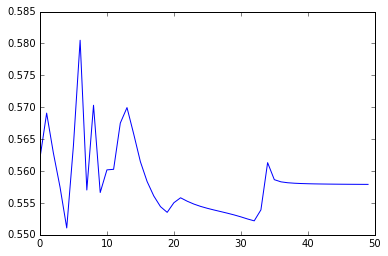

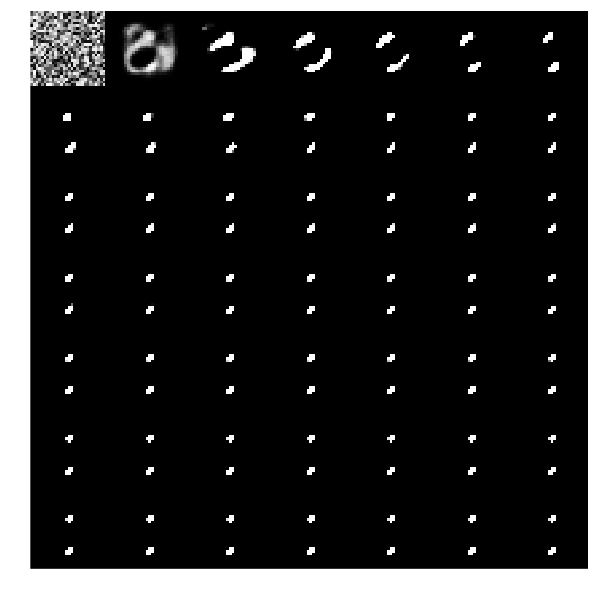

In [223]:
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(jac)
print("Nb of iterations", len(loss))
fig = plt.figure(figsize=(10, 10))
if samples.shape[1] == 1:
    sz = int(np.sqrt(samples.shape[0]))
    img = tile_raster_images(samples[:, 0], (w, h), (sz, sz), tile_spacing=(2, 2), )
    plt.imshow(img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()
else:
    ss = s.transpose((0, 2, 3, 1))
    img = dispims_color(ss)
    plt.imshow(img)
    plt.axis('off')
    plt.show()